# Init things

In [1]:
import numpy as np
from astropy.io import fits
import numpy as np
import astropy.units as u
import astropy.constants as const

import pprint
import logging
import os

import matplotlib
import matplotlib.pyplot as plt
%pylab inline
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['axes.linewidth'] = 1.
matplotlib.rcParams['lines.linewidth'] = 2.5
matplotlib.rcParams['font.size'] = 15

import scipy.ndimage.interpolation
import scipy.signal
import skimage.transform


cmap='inferno'

Populating the interactive namespace from numpy and matplotlib


# Test wavelength interpolation

In [2]:
spc_psf_path = '/Users/mrizzo/IFS/OS6/SPC/spc_os6/'
psf_series_fname = spc_psf_path+'os6_spc_770nm_muf_images.fits'

In [3]:
psf_series = fits.open(psf_series_fname)[0].data[0]

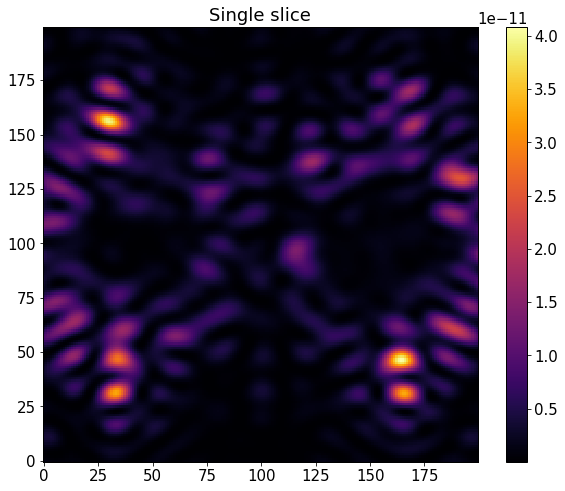

In [4]:
plt.figure(figsize=(10,8))
plt.imshow(psf_series[0],cmap=cmap)
plt.title('Single slice')
plt.colorbar()

In [6]:
wavel = np.linspace(0.7,0.84,11)
print wavel

[ 0.7    0.714  0.728  0.742  0.756  0.77   0.784  0.798  0.812  0.826
  0.84 ]


## Spline interpolate

In [6]:
import scipy.ndimage as ndimage
data_filtered = ndimage.spline_filter(psf_series,order=3)


## Create maps

In [8]:
nl,nx,ny = psf_series.shape
x = np.arange(nx)
y = np.arange(ny)
new_wavel = np.linspace(0.7,0.84,25)
l = (new_wavel-0.7)*(nl-1)/(0.84-0.7)
print l
print new_wavel
l,x,y = np.meshgrid(l,x,y)
newpsf = ndimage.map_coordinates(data_filtered,[l,x,y],prefilter=True,mode='nearest')
newpsf = np.swapaxes(newpsf,0,1)

NameError: name 'psf_series' is not defined

(25, 200, 200) (200, 25, 200)


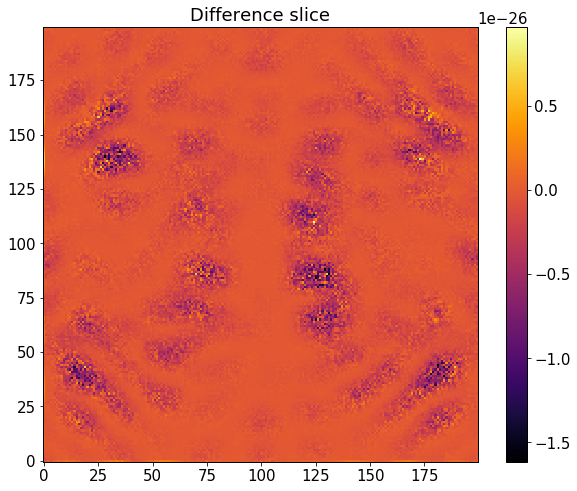

In [8]:
print newpsf.shape,l.shape
plt.figure(figsize=(10,8))
plt.imshow(newpsf[-1]-data_filtered[-1],cmap=cmap)
plt.title('Difference slice')
plt.colorbar()

In [9]:
fits.writeto('/Users/mrizzo/Downloads/interpolated.fits',newpsf,overwrite=True)
fits.writeto('/Users/mrizzo/Downloads/data_filtered.fits',data_filtered,overwrite=True)

## Turn into function

In [14]:
def interp(data,new_wavel):
    nl,nx,ny = data.shape
    x = np.arange(nx)
    y = np.arange(ny)
    new_wavel = np.linspace(0.7,0.84,25)
    l = (new_wavel-np.amin(new_wavel))*(nl-1)/(np.amax(new_wavel)-np.amin(new_wavel))
    l,x,y = np.meshgrid(l,x,y)
    newpsf = ndimage.map_coordinates(data,[l,x,y],prefilter=False,mode='nearest',order=1)
    return np.swapaxes(newpsf,0,1)

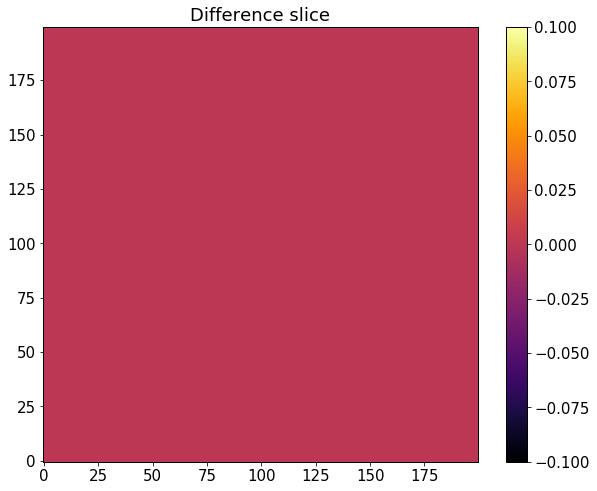

In [100]:
new = interp(psf_series,new_wavel)
plt.figure(figsize=(10,8))
plt.imshow(new[0]-psf_series[0],cmap=cmap)
plt.title('Difference slice')
plt.colorbar()
fits.writeto('/Users/mrizzo/Downloads/newinterp.fits',new,overwrite=True)
fits.writeto('/Users/mrizzo/Downloads/psf_series.fits',psf_series,overwrite=True)


# Flux normalization

In [10]:
import astropy.units as u
# erg s-1 cm-2 Ang-1
flam = u.erg/u.s/u.cm**2/u.Angstrom
fac = flam.to(u.W/u.m**2/u.nm)
print fac

0.01


## Load G0V star

Text(0,0.5,u'Flux (W.m$^{-2}$.nm$^{-1}$)')

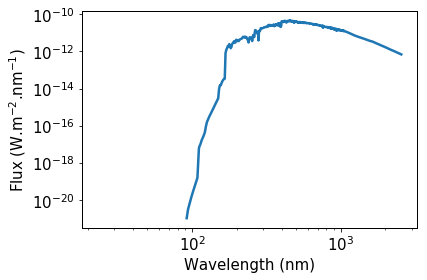

In [11]:
Vmag = 0
g0v_fits = fits.open('/Users/mrizzo/Downloads/grp 2/hst/cdbs/grid/bpgs/bpgs_35.fits')
g0v = np.array(g0v_fits[1].data)
dat = g0v['FLUX']*fac*10**(-0.4 * Vmag)
wav = g0v['WAVELENGTH']/10
plt.loglog(wav,dat)
plt.xlabel('Wavelength (nm)')
plt.ylabel(r'Flux (W.m$^{-2}$.nm$^{-1}$)')


## Interpolate to the correct wavelengths

In [12]:
from scipy.interpolate import interp1d
wavel_hlc = np.arange(546.,604.)/1000.

func = interp1d(wav,dat,bounds_error=False,fill_value=0.0)
g0vflux = func(wavel_hlc*1000)*u.W/u.m**2/u.nm
print g0vflux

[  3.69624782e-11   3.64935374e-11   3.65044418e-11   3.62550719e-11
   3.66789342e-11   3.66571218e-11   3.67407285e-11   3.67879893e-11
   3.65807870e-11   3.65953240e-11   3.67843533e-11   3.59064584e-11
   3.56694431e-11   3.54371567e-11   3.44229402e-11   3.57810448e-11
   3.58610190e-11   3.52830265e-11   3.56414551e-11   3.56552669e-11
   3.52877554e-11   3.49227799e-11   3.52797548e-11   3.52234110e-11
   3.48951527e-11   3.46057905e-11   3.50914540e-11   3.53709978e-11
   3.56814439e-11   3.51928747e-11   3.47043054e-11   3.47982754e-11
   3.48922453e-11   3.51158096e-11   3.53393738e-11   3.55593003e-11
   3.57792268e-11   3.54955006e-11   3.52117745e-11   3.51236228e-11
   3.50354711e-11   3.44874684e-11   3.39394658e-11   3.34612581e-11
   3.29830503e-11   3.34986986e-11   3.40143469e-11   3.41659340e-11
   3.43175210e-11   3.42791715e-11   3.42408220e-11   3.39420107e-11
   3.36431993e-11   3.36539234e-11   3.36646475e-11   3.34928838e-11
   3.33211202e-11   3.34216335e-11

## Convert to correct units

[  1.01596091e+08   1.00490860e+08   1.00704655e+08   1.00199231e+08
   1.01555318e+08   1.01679461e+08   1.02096326e+08   1.02412851e+08
   1.02020180e+08   1.02244947e+08   1.02958259e+08   1.00681816e+08
   1.00196789e+08   9.97226823e+07   9.70418940e+07   1.01050660e+08
   1.01457047e+08   9.99994245e+07   1.01194709e+08   1.01413417e+08
   1.00545755e+08   9.96816323e+07   1.00878164e+08   1.00894374e+08
   1.00129774e+08   9.94736736e+07   1.01046359e+08   1.02029371e+08
   1.03104492e+08   1.01869896e+08   1.00630380e+08   1.01078039e+08
   1.01526644e+08   1.02353930e+08   1.03183467e+08   1.04004616e+08
   1.04827978e+08   1.04175390e+08   1.03519945e+08   1.03437602e+08
   1.03354372e+08   1.01911382e+08   1.00462875e+08   9.92157992e+07
   9.79639085e+07   9.96640867e+07   1.01369457e+08   1.01993211e+08
   1.02618492e+08   1.02676382e+08   1.02733886e+08   1.02008220e+08
   1.01279546e+08   1.01481248e+08   1.01683057e+08   1.01332858e+08
   1.00980928e+08   1.01453786e+08

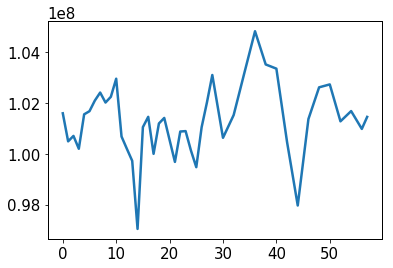

In [13]:
import astropy.constants as c
Eph = (c.c*c.h/(wavel_hlc*u.um)/u.photon).to(u.J/u.photon)
print (g0vflux/Eph).to(u.photon/u.s/u.m**2/u.nm)
plt.plot((g0vflux/Eph).to(u.photon/u.s/u.m**2/u.nm))

## Create function

In [11]:
from scipy.interpolate import interp1d
import astropy.constants as c
import astropy.units as u


def input_star(starfile,Vmag,wavel):
    '''
    Paramters
    ---------
    
    starfile: string
        Text file corresponding to the bpgs specturm in pysynphot catalog
    Vmag: float
        V magnitude of star
    wavel: array
        Array of desired wavelengths in microns
    '''
    fopen = fits.open(starfile)
    f = np.array(fopen[1].data)
    # erg s-1 cm-2 Ang-1
    flam = u.erg/u.s/u.cm**2/u.Angstrom
    fac = flam.to(u.W/u.m**2/u.nm)
    dat = f['FLUX']*fac*10**(-0.4 * Vmag)
    wav = f['WAVELENGTH']/10
    func = interp1d(wav,dat,bounds_error=False,fill_value=0.0)
    flux = func(wavel*1000)*u.W/u.m**2/u.nm
    Eph = (c.c*c.h/(wavel*u.um)/u.photon).to(u.J/u.photon)
    return (flux/Eph).to(u.photon/u.s/u.m**2/u.nm)


## Test conversion with HLC numbers in Vband

In [15]:
wavel_hlc = np.arange(546.,604.)/1000.
star = input_star('/Users/mrizzo/Downloads/grp 2/hst/cdbs/grid/bpgs/bpgs_7.fits',5,wavel_hlc)
startot = np.sum(star)*1*u.nm*3.6825*u.m**2*0.57*0.9*120*u.s
print '{:e}'.format(startot)
print 'Compare to 1.38e10 ph in John Krist OS6, {:.2f}% difference'.format(100*np.abs(startot-1.38e10*u.ph)/startot)

1.182743e+10 ph
Compare to 1.38e10 ph in John Krist OS6, 16.68% difference


## Load both target and reference stars

In [12]:
target_star_conv = input_star('/Users/mrizzo/Downloads/grp 2/hst/cdbs/grid/bpgs/bpgs_35.fits',5,new_wavel)*3.68*u.m**2
ref_star_conv = input_star('/Users/mrizzo/Downloads/grp 2/hst/cdbs/grid/bpgs/bpgs_7.fits',1.8,new_wavel)*3.68*u.m**2
dlam = new_wavel[1]-new_wavel[0]
dlam *= 1000*u.nm
print "Target total photons flux density: {:e}".format(np.sum(target_star_conv)*dlam)
print "Ref total photons flux density: {:e}".format(np.sum(ref_star_conv)*dlam)

Target total photons flux density: 4.636527e+08 ph / s
Ref total photons flux density: 4.498626e+09 ph / s


# Test IFS propagation with John Krist's files

In [51]:

from crispy.IFS import polychromeIFS
from crispy.tools.initLogger import getLogger
from crispy.tools.image import Image
log = getLogger('crispy')
os.chdir('/Users/mrizzo/IFS/crispy/crispy/WFIRST/')
from params import Params
par = Params()
fieldmask = fits.getdata(spc_psf_path+'field_mask.fits')
psf = Image(data=newpsf*ref_star_conv[:,np.newaxis,np.newaxis]*fieldmask[np.newaxis,:,:])
# psf = Image(data=newpsf*ref_star_conv[:,np.newaxis,np.newaxis])
psf.header['LAM_C'] = 0.77
psf.header['PIXSIZE'] = 0.1
wav = new_wavel

detector = polychromeIFS(par,wav*1000,psf,QE=True)
fits.writeto('/Users/mrizzo/Downloads/testIFS.fits',detector,overwrite=True)

crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Writing data to ..//SimResults/detectorFramepoly.fits
crispy - INFO - Writing data to ..//SimResults/detectorFrame.fits
crispy - INFO - Done.
crispy - INFO - Performance: 16 seconds total


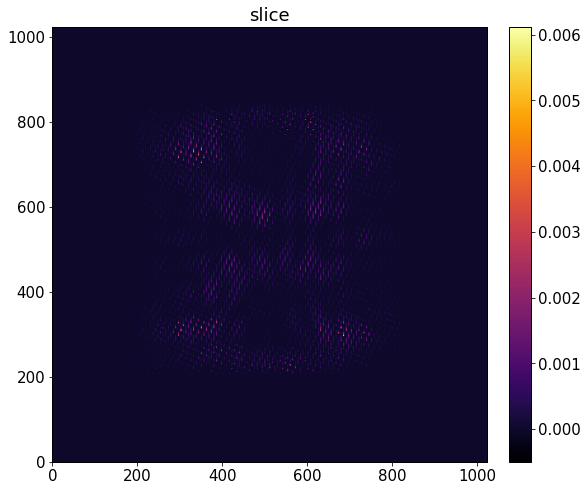

In [38]:
plt.figure(figsize=(10,8))
plt.imshow(detector.T,cmap=cmap)
plt.title('slice')
plt.colorbar(fraction=0.046, pad=0.04)

## Readout

In [70]:
detector = fits.getdata('/Users/mrizzo/Downloads/testIFS.fits')
from crispy.tools.detector import readoutPhotonFluxMapWFIRST as readoutWFIRST
detector[detector<0] = 0.0
obs = np.zeros_like(detector)
for i in range(1):
    if i%10==0: print i
    obsi = readoutWFIRST(detector.T,
                        tottime=120,
                        inttime=120,
                        PCcorrect=False, # don't correct for photon counting bias
                        PCmode = False,
                        crrate = 5.0,
                        EMGain = 5000.,
                        hprate=3.0,
                        lifefraction=0.0,
                        xs=2048,ys=1024,
                        QE = 1.0,
                        ).astype(np.int)
    for ix in range(1024):
        for iy in range(1024):
            if obsi[ix,iy]>65000:
                obsi[ix,iy:] = 0
                continue
#     mask = obsi>600
#     obsi[mask] = 1
#     obsi[~mask] = 0
    obs += obsi
fits.writeto('/Users/mrizzo/Downloads/obsIFS.fits',obs,overwrite=True)

0


In [63]:
from crispy.IFS import reduceIFSMap
from crispy.tools.image import Image

obsIFS = Image('/Users/mrizzo/Downloads/obsIFS.fits')
detector = reduceIFSMap(par,obsIFS.data.T,name='obsIFS',
                        method='optext',
                        smoothbad=False,
                        pixnoise=0,
                        fitbkgnd=False,
                        medsub=False,
                        gain=1.0,
                        niter=3
                       )

crispy - INFO - Read data from HDU 0 of /Users/mrizzo/Downloads/obsIFS.fits
crispy - INFO - Mean, median, std: (1.2937820057429137, 1.0, 1.1674770422566385)
crispy - INFO - Reduced cube will have 18 wavelength bins
crispy - INFO - Elapsed time: 2.830823s


# Apply to all files

## Propagate through IFS

In [19]:
from IPython.display import clear_output
psf_series_fname = spc_psf_path+'os6_spc_770nm_muf_images.fits'
fieldmask = fits.getdata(spc_psf_path+'field_mask.fits')

timesteps_fname = os.path.join(spc_psf_path+'os6_timesteps.txt')
timesteps = np.loadtxt(timesteps_fname,skiprows=1)
startype = timesteps[:,0]

# convert_cube_ref = ref_star_conv[:,np.newaxis,np.newaxis]*fieldmask[np.newaxis,:,:]
# convert_cube_target = target_star_conv[:,np.newaxis,np.newaxis]*fieldmask[np.newaxis,:,:]
# without field stop
convert_cube_ref = ref_star_conv[:,np.newaxis,np.newaxis]
convert_cube_target = target_star_conv[:,np.newaxis,np.newaxis]
par.saveDetector = False
par.savePoly = False
for i in range(3630):
    clear_output()
    print i,'/3630'
    openpsf = fits.open(psf_series_fname)[0].data[i]
    newpsf = interp(openpsf,new_wavel)
    if startype[i]==1: psf = Image(data=newpsf*convert_cube_ref)
    else: psf = Image(data=newpsf*convert_cube_target)
    psf.header['LAM_C'] = 0.77
    psf.header['PIXSIZE'] = 0.1
    detector = polychromeIFS(par,new_wavel*1000,psf,QE=True)
    fits.writeto('/Users/mrizzo/IFS/OS6/SPC/IFSraw/os6_%d.fits' % i,detector,overwrite=True)

0 /3630
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates


Process Consumer-1:
    self.run()
Process Consumer-8:
Process Consumer-3:
Traceback (most recent call last):
Process Consumer-6:
Traceback (most recent call last):
Process Consumer-4:
  File "/Users/mrizzo/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/Users/mrizzo/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/mrizzo/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/Users/mrizzo/anaconda2/lib/python2.7/site-packages/crispy-0.3-py2.7.egg/crispy/tools/par_utils.py", line 23, in run
Traceback (most recent call last):
  File "/Users/mrizzo/anaconda2/lib/python2.7/site-packages/crispy-0.3-py2.7.egg/crispy/tools/par_utils.py", line 23, in run
    self.run()
    self.result_queue.put(next_task())
    self.result_queue.put(next_task())


KeyboardInterrupt: 

  File "/Users/mrizzo/anaconda2/lib/python2.7/site-packages/crispy-0.3-py2.7.egg/crispy/tools/par_utils.py", line 34, in __call__
  File "/Users/mrizzo/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/Users/mrizzo/anaconda2/lib/python2.7/site-packages/crispy-0.3-py2.7.egg/crispy/tools/par_utils.py", line 34, in __call__
  File "/Users/mrizzo/anaconda2/lib/python2.7/site-packages/crispy-0.3-py2.7.egg/crispy/tools/par_utils.py", line 23, in run
    return self.index, self.func(*self.args)
    return self.index, self.func(*self.args)
Process Consumer-7:
  File "/Users/mrizzo/anaconda2/lib/python2.7/site-packages/crispy-0.3-py2.7.egg/crispy/tools/lenslet.py", line 241, in propagateLenslets
  File "/Users/mrizzo/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.result_queue.put(next_task())
    prefilter=False) / nlam
  File "/Users/mrizzo/anaconda2/lib/python2.7/site-packages/crispy-0.3-py2.7.egg/crispy/tools/lenslet.

## Readout maps

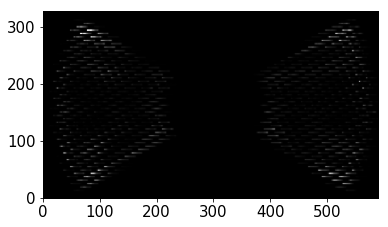

In [116]:
fname = '/Users/mrizzo/IFS/OS6/SPC/IFSraw/os6_%d.fits' % 0
hdu = fits.open(fname)
o = hdu[0].data[350:680,225:815]
plt.imshow(o)

In [3]:
from crispy.tools.detector import readoutPhotonFluxMapWFIRST as readoutWFIRST

timesteps_fname = os.path.join(spc_psf_path, 'os6_timesteps.txt')
timesteps = np.loadtxt(timesteps_fname,skiprows=1)

print timesteps.shape
startype = timesteps[:,0]
timestep = timesteps[:,1]
roll = timesteps[:,3]

Ndat_in_chunk = 55 # number of frames in a single chunk
datsize = timesteps.shape[0]

chunks_ind = np.split(np.arange(datsize),datsize/Ndat_in_chunk)
print "Number of chunks:",len(chunks_ind)

(3630, 4)
Number of chunks: 66


In [4]:
data_average=[]
for j in range(len(chunks_ind)):
    chunk_indiv_frame = []
    if j%(len(chunks_ind)//10)==0: print j,"/",len(chunks_ind)
    for i in range(len(chunks_ind[j])):
        ind = chunks_ind[j][i]
        fname = '/Users/mrizzo/IFS/OS6/SPC/IFSraw/os6_%d.fits' % ind
        hdu = fits.open(fname)
        o = hdu[0].data[350:680,225:815]
        o[o<0.0] = 0.0
        obs = readoutWFIRST(o.T,
                                tottime=120,
                                inttime=120,
                                PCcorrect=False, # don't correct for photon counting bias
                                PCmode = False,
                                crrate = 5.0,
                                hprate = 0.0,
                                lifefraction=0.5,
                                xs=1000,ys=600,
                                QE = 1.0,
                                ).astype(np.int)
        hdu.close()
        for ix in range(obs.shape[0]):
            for iy in range(obs.shape[1]):
                if obs[ix,iy]>65000:
                    obs[ix,iy:] = 0
                    continue

        mask = obs>600
        obs[mask] = 1
        obs[~mask] = 0
        chunk_indiv_frame.append(obs)
    data_average.append(np.nansum(np.array(chunk_indiv_frame),axis=0))
data_average = np.array(data_average)

0 / 66
6 / 66


KeyboardInterrupt: 

In [136]:
fits.writeto('/Users/mrizzo/Downloads/spc_ifs_CR_PC_no_HP.fits',data_average, overwrite=True)


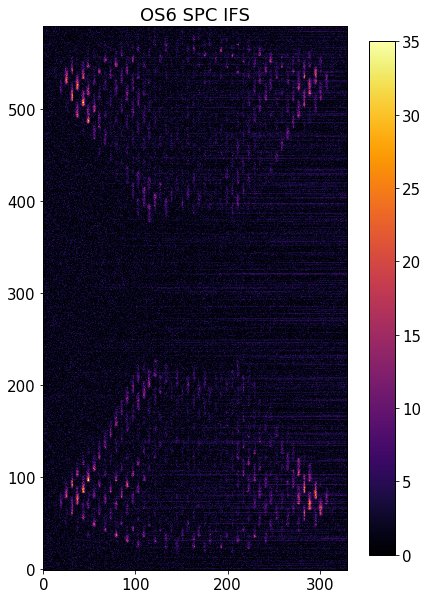

In [137]:
plt.figure(figsize=(10,10))
plt.title('OS6 SPC IFS')
plt.imshow(data_average[0],cmap=cmap)
plt.colorbar(fraction=0.046, pad=0.04)


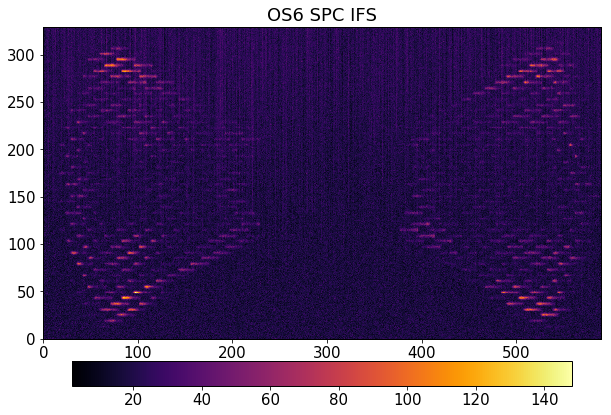

In [140]:
ave = np.zeros_like(data_average[0])
for i in range(len(data_average)):
    if startype[i]!=1: ave += data_average[i]
plt.figure(figsize=(10,10))
plt.title('OS6 SPC IFS')
plt.imshow(ave.T,cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
fits.writeto('/Users/mrizzo/Downloads/spc_ifs_ave_CR_PC_no_HP.fits',ave, overwrite=True)


## Extract IFS map

In [145]:
IFSmap = np.zeros((1024,1024))
IFSmap[350:680,225:815] = ave.T-18

detector = reduceIFSMap(par,IFSmap,name='aveIFS',
                        method='lstsq_conv',
                        smoothbad=False,
                        pixnoise=18,
                        fitbkgnd=False,
                        medsub=False,
                        gain=1.0,
                        niter=5
                       )

crispy - INFO - Mean, median, std: (0.0, 0.0, 0.0)
crispy - INFO - Reduced cube will have 18 wavelength bins
crispy - INFO - Writing data to ..//SimResults/aveIFS_red_lstsq_conv_resid.fits
crispy - INFO - Writing data to ..//SimResults/aveIFS_red_lstsq_conv_model.fits
crispy - INFO - Writing data to ..//SimResults/aveIFS_red_lstsq_conv_chisq.fits
crispy - INFO - Elapsed time: 37.393289s


# Add the planet

In [158]:
planetpsf_roll1 = fits.getdata(spc_psf_path+'planet_psfs/os6_spc_770nm_psf_3.41_-0.79.fits')
roll1 = interp(planetpsf_roll1,new_wavel)
fits.writeto('/Users/mrizzo/Downloads/planetpsf_roll1.fits',roll1,overwrite=True)
planetpsf_roll2 = fits.getdata(spc_psf_path+'planet_psfs/os6_spc_770nm_psf_3.41_0.79.fits')
roll2 = interp(planetpsf_roll2,new_wavel)
fits.writeto('/Users/mrizzo/Downloads/planetpsf_roll2.fits',roll2,overwrite=True)

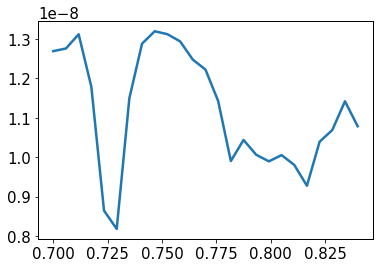

In [159]:
from crispy.tools.inputScene import calc_contrast

contrast = calc_contrast(new_wavel*1000,1.5,1,par.codeRoot +'/Inputs/Jupiter_1x_5AU_90deg.dat').value
plt.plot(new_wavel,contrast)

In [160]:
psf_roll1 = Image(data=roll1*convert_cube_target*contrast[:,np.newaxis,np.newaxis])
psf_roll1.header['LAM_C'] = 0.77
psf_roll1.header['PIXSIZE'] = 0.1
offaxis_roll1 = polychromeIFS(par,new_wavel*1000,psf_roll1,QE=True)
fits.writeto('/Users/mrizzo/IFS/OS6/SPC/IFSraw/offaxis_roll1.fits',offaxis_roll1,overwrite=True)
psf_roll2 = Image(data=roll2*convert_cube_target*contrast[:,np.newaxis,np.newaxis])
psf_roll2.header['LAM_C'] = 0.77
psf_roll2.header['PIXSIZE'] = 0.1
offaxis_roll2 = polychromeIFS(par,new_wavel*1000,psf_roll2,QE=True)
fits.writeto('/Users/mrizzo/IFS/OS6/SPC/IFSraw/offaxis_roll2.fits',offaxis_roll2,overwrite=True)

crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 18 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 20 seconds total


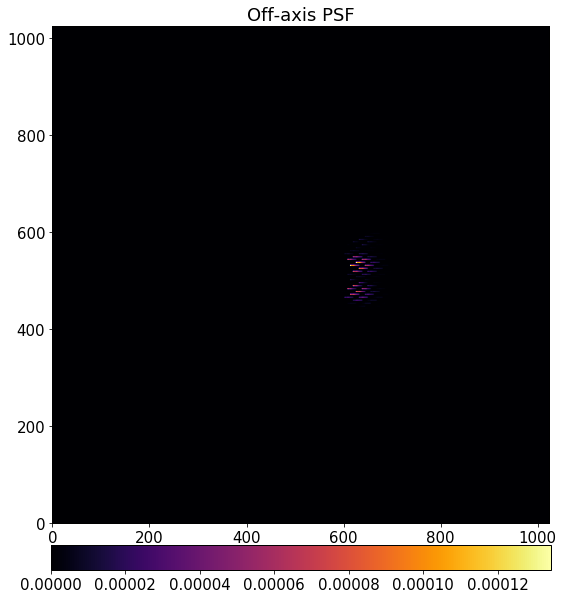

In [162]:
plt.figure(figsize=(10,10))
plt.title('Off-axis PSF')
plt.imshow(offaxis_roll2,cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)


# Re-run with planet

In [289]:
from crispy.tools.detector import readoutPhotonFluxMapWFIRST as readoutWFIRST

timesteps_fname = os.path.join(spc_psf_path, 'os6_timesteps.txt')
timesteps = np.loadtxt(timesteps_fname,skiprows=1)

print timesteps.shape
startype = timesteps[:,0]
timestep = timesteps[:,1]
roll = timesteps[:,3]

Ndat_in_chunk = 55 # number of frames in a single chunk
datsize = timesteps.shape[0]

chunks_ind = np.split(np.arange(datsize),datsize/Ndat_in_chunk)
print "Number of chunks:",len(chunks_ind)

data_average=[]
for j in range(len(chunks_ind)):
    chunk_indiv_frame = []
    if j%(len(chunks_ind)//10)==0: print j,"/",len(chunks_ind)
    for i in range(len(chunks_ind[j])):
        ind = chunks_ind[j][i]
        fname = '/Users/mrizzo/IFS/OS6/SPC/IFSraw/os6_%d.fits' % ind
        hdu = fits.open(fname)
        o = hdu[0].data#[350:680,225:815]
        if startype[ind]!=1: 
            if roll[ind]==1 or roll[ind]==3: o += offaxis_roll1#[350:680,225:815]
            else: o += offaxis_roll2#[350:680,225:815]
        o[o<0.0] = 0.0
        obs = readoutWFIRST(o.T,
                                tottime=120,
                                inttime=120,
                                PCcorrect=False, # don't correct for photon counting bias
                                PCmode = False,
                                crrate = 0.0,
                                hprate = 0.0,
                                lifefraction=0.0,
                                xs=1024,ys=1024,
#                                 xs=500,ys=600,
                                QE = 1.0,
                                ).astype(np.int)
        hdu.close()
#         for ix in range(obs.shape[0]):
#             for iy in range(obs.shape[1]):
#                 if obs[ix,iy]>65000:
#                     obs[ix,iy:] = 0
#                     continue

#         mask = obs>600
#         obs[mask] = 1
#         obs[~mask] = 0
        fits.writeto('/Users/mrizzo/IFS/OS6/SPC/IFSdetector/os6_%d.fits' % ind,obs,overwrite=True)
        chunk_indiv_frame.append(obs)
    data_average.append(np.nansum(np.array(chunk_indiv_frame),axis=0))
data_average = np.array(data_average)



(3630, 4)
Number of chunks: 66
0 / 66
6 / 66
12 / 66
18 / 66
24 / 66
30 / 66
36 / 66
42 / 66
48 / 66
54 / 66
60 / 66


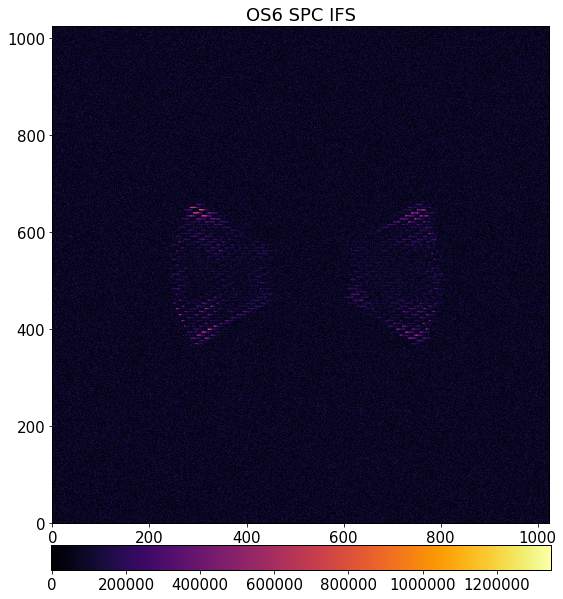

In [293]:
ave = np.zeros_like(data_average[0])
for i in range(len(data_average)):
    if startype[i]!=1: ave += data_average[i]
plt.figure(figsize=(10,10))
plt.title('OS6 SPC IFS')
plt.imshow(ave.T,cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)


## Process files

In [294]:
timesteps_fname = os.path.join(spc_psf_path, 'os6_timesteps.txt')
timesteps = np.loadtxt(timesteps_fname,skiprows=1)

print timesteps.shape
startype = timesteps[:,0]
timestep = timesteps[:,1]
roll = timesteps[:,3]


Ndat_in_chunk = 55 # number of frames in a single chunk
datsize = timesteps.shape[0]
reference_chunks_ind = []
roll_plus_chunks_ind = []
roll_minus_chunks_ind = []
# cut into chunks
chunks_ind = np.split(np.arange(datsize),datsize/Ndat_in_chunk)



for j in range(len(chunks_ind)):
    i = chunks_ind[j][0]
    if startype[i]==1: reference_chunks_ind.append(chunks_ind[j])
    elif roll[i]==1 or roll[i]==3: roll_minus_chunks_ind.append(chunks_ind[j])
    else: roll_plus_chunks_ind.append(chunks_ind[j])



print 'Summary:'
print 'There are %d reference chunks' % len(reference_chunks_ind)
print 'There are %d target chunks with minus 13deg roll' % len(roll_minus_chunks_ind)
print 'There are %d target chunks with plus 13deg roll' % len(roll_plus_chunks_ind)


from crispy.tools.detector import readoutPhotonFluxMapWFIRST as readoutWFIRST
reference_data_average = []
for j in range(len(reference_chunks_ind)):
    chunk_indiv_frame = []
    for i in range(len(reference_chunks_ind[j])):
        ind = reference_chunks_ind[j][i]
        fname = '/Users/mrizzo/IFS/OS6/SPC/IFSdetector/os6_%d.fits' % ind
        hdu = fits.open(fname)
        obs = hdu[0].data
        hdu.close()
#         for ix in range(obs.shape[0]):
#             for iy in range(obs.shape[1]):
#                 if obs[ix,iy]>65000:
#                     obs[ix,:] = 0
#                     obs[ix+1,:] = 0
#                     continue
        mask = obs>600
        obs[mask] = 1
        obs[~mask] = 0
        chunk_indiv_frame.append(obs)
    reference_data_average.append(np.nansum(chunk_indiv_frame,axis=0))
print 'Done with reference'
roll_minus_data_average = []
for j in range(len(roll_minus_chunks_ind)):
    chunk_indiv_frame = []
    for i in range(len(roll_minus_chunks_ind[j])):
        ind = roll_minus_chunks_ind[j][i]
        fname = '/Users/mrizzo/IFS/OS6/SPC/IFSdetector/os6_%d.fits' % ind
        hdu = fits.open(fname)
        obs = hdu[0].data
        hdu.close()
#         for ix in range(obs.shape[0]):
#             for iy in range(obs.shape[1]):
#                 if obs[ix,iy]>65000:
#                     obs[ix,:] = 0
#                     obs[ix+1,:] = 0
#                     continue
        mask = obs>600
        obs[mask] = 1
        obs[~mask] = 0
        chunk_indiv_frame.append(obs)
    roll_minus_data_average.append(np.nansum(chunk_indiv_frame,axis=0))
print 'Done with minus roll'

roll_plus_data_average = []
for j in range(len(roll_plus_chunks_ind)):
    chunk_indiv_frame = []
    for i in range(len(roll_plus_chunks_ind[j])):
        ind = roll_plus_chunks_ind[j][i]
        fname = '/Users/mrizzo/IFS/OS6/SPC/IFSdetector/os6_%d.fits' % ind
        hdu = fits.open(fname)
        obs = hdu[0].data
        hdu.close()
        
#         for ix in range(obs.shape[0]):
#             for iy in range(obs.shape[1]):
#                 if obs[ix,iy]>65000:
#                     obs[ix,:] = 0
#                     obs[ix+1,:] = 0
#                     continue
        mask = obs>600
        obs[mask] = 1
        obs[~mask] = 0
        chunk_indiv_frame.append(obs)
    roll_plus_data_average.append(np.nansum(chunk_indiv_frame,axis=0))
print 'Done with plus roll'


fits.writeto('/Users/mrizzo/IFS/OS6/references_haystacks_spc.fits',np.array(reference_data_average), overwrite=True)
fits.writeto('/Users/mrizzo/IFS/OS6/roll_minus_haystacks_spc.fits',np.array(roll_minus_data_average), overwrite=True)
fits.writeto('/Users/mrizzo/IFS/OS6/roll_plus_haystacks_spc.fits',np.array(roll_plus_data_average), overwrite=True)

(3630, 4)
Summary:
There are 14 reference chunks
There are 26 target chunks with minus 13deg roll
There are 26 target chunks with plus 13deg roll
Done with reference
Done with minus roll


In [295]:
ref = np.mean(np.array(reference_data_average),axis=0)
minus = np.mean(np.array(roll_minus_data_average),axis=0)
plus = np.mean(np.array(roll_plus_data_average),axis=0)

In [296]:
fits.writeto('/Users/mrizzo/IFS/OS6/roll_minus_haystacks_spc_ave.fits',minus, overwrite=True)
fits.writeto('/Users/mrizzo/IFS/OS6/ref_haystacks_spc_ave.fits',ref, overwrite=True)
fits.writeto('/Users/mrizzo/IFS/OS6/roll_plus_haystacks_spc_ave.fits',plus, overwrite=True)


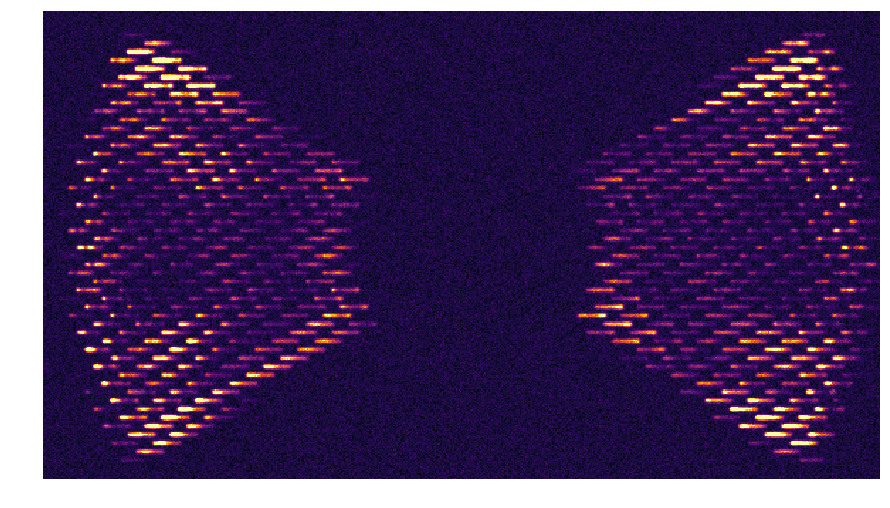

In [319]:
plt.figure(figsize=(15,15))
# plt.title('OS6 SPC IFS, Average of reference Star (ph/6600s)')
plt.imshow(np.mean(np.array(reference_data_average),axis=0).T[350:680,225:815],cmap=cmap,vmax = 10)
# plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.axis('off')
plt.savefig('/Users/mrizzo/Downloads/Reference_Average.png',dpi=300)

## Extract IFS maps

In [362]:
IFSmap = np.zeros((1024,1024))
# IFSmap[350:680,225:815] = ref.T-1
IFSmap = ref.T-1

refIFS = reduceIFSMap(par,IFSmap,name='refIFS',
                        method='sum',
                        smoothbad=False,
                        pixnoise=2,
                        fitbkgnd=False,
                        medsub=False,
                        gain=1.0,
                        niter=5
                       )
# IFSmap[350:680,225:815] = plus.T-1
IFSmap = plus.T-1

plusIFS = reduceIFSMap(par,IFSmap,name='plusIFS',
                        method='sum',
                        smoothbad=False,
                        pixnoise=2,
                        fitbkgnd=False,
                        medsub=False,
                        gain=1.0,
                        niter=5
                       )
# IFSmap[350:680,225:815] = minus.T-1
IFSmap = minus.T-1

minusIFS = reduceIFSMap(par,IFSmap,name='minusIFS',
                        method='sum',
                        smoothbad=False,
                        pixnoise=2,
                        fitbkgnd=False,
                        medsub=False,
                        gain=1.0,
                        niter=5
                       )

crispy - INFO - Mean, median, std: (0.2972950220532718, 0.28571428571428581, 0.3001249933110014)
crispy - INFO - Reduced cube will have 18 wavelength bins
crispy - INFO - Elapsed time: 2.752403s
crispy - INFO - Mean, median, std: (0.29584484807914413, 0.30769230769230771, 0.22053855391669003)
crispy - INFO - Reduced cube will have 18 wavelength bins
crispy - INFO - Elapsed time: 2.804615s
crispy - INFO - Mean, median, std: (0.2956275711434232, 0.30769230769230771, 0.22042065241164535)
crispy - INFO - Reduced cube will have 18 wavelength bins
crispy - INFO - Elapsed time: 2.630096s


## Make video

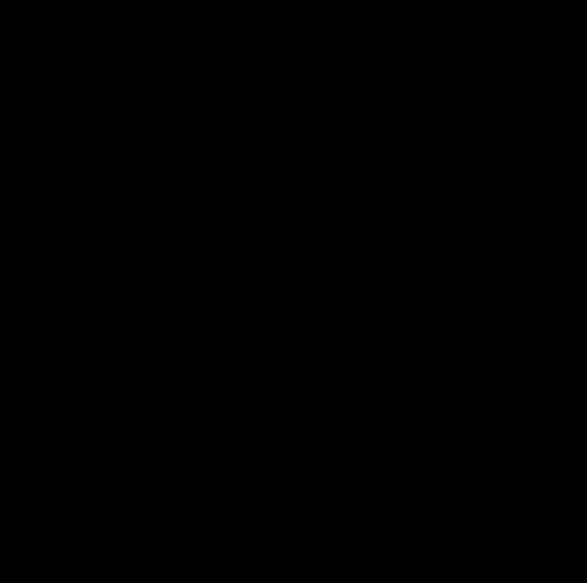

In [299]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.animation as animation
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Maxime Rizzo'), bitrate=1800)

ims = []

fig = plt.figure(figsize=(10,10),facecolor='black')
trim = 30
plt.axis('off')
ims.append((plt.imshow(refIFS.data[0,trim:-trim,trim:-trim],cmap=cmap),))
ims.append((plt.imshow(plusIFS.data[0,trim:-trim,trim:-trim],cmap=cmap),))
ims.append((plt.imshow(minusIFS.data[0,trim:-trim,trim:-trim],cmap=cmap),))

im_ani = animation.ArtistAnimation(fig, ims, interval=500, repeat_delay=3000)
im_ani.save('/Users/mrizzo/Downloads/OS6_IFS_noisy.mp4', writer=writer,savefig_kwargs={'facecolor':'none'})


## Inspect

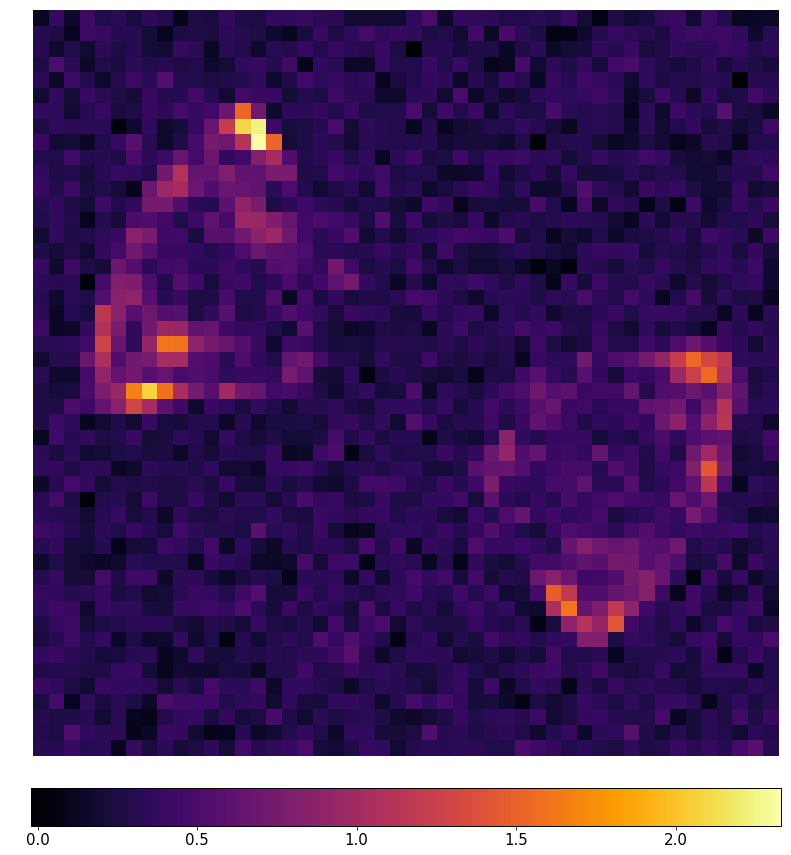

In [363]:
plt.figure(figsize=(15,15))
plt.imshow(minusIFS.data[0][crop:-crop,crop:-crop],cmap=cmap)
plt.axis('off')
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.savefig('/Users/mrizzo/Downloads/Minus_beofre_RDI.png',dpi=300)

## Construct mask

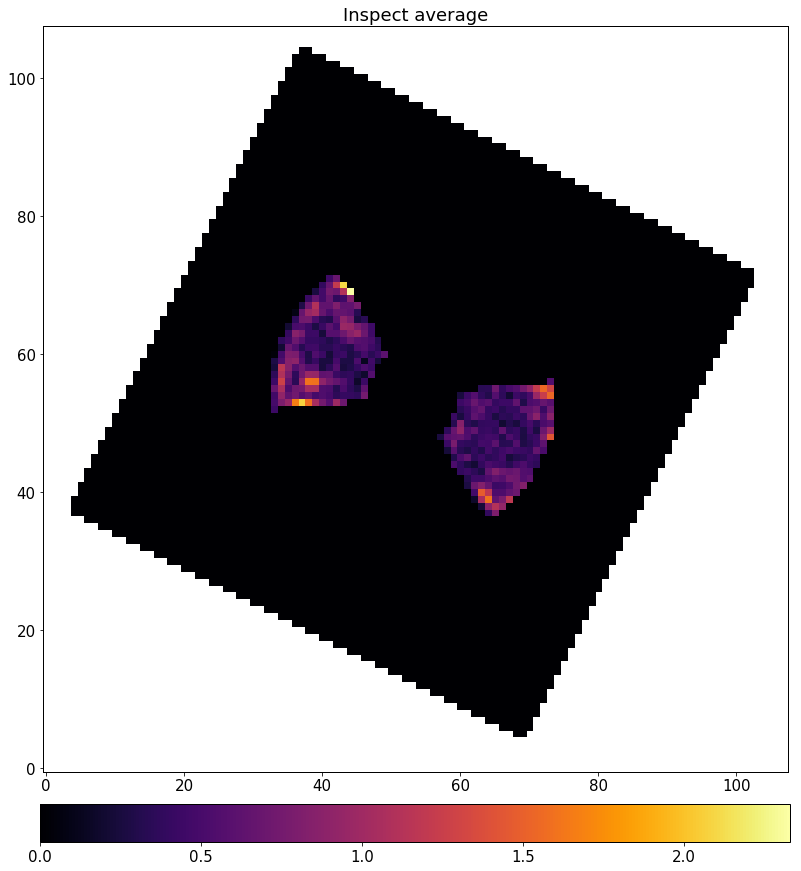

In [364]:
from crispy.tools.imgtools import bowtie

ydim,xdim=minusIFS.data[0].shape
lamc=770.
IWA = 2.8
OWA=9.
mask, scratch = bowtie(minusIFS.data[0], ydim //
                       2 -
                       1, xdim //
                       2, openingAngle=65, clocking=-
                       par.philens *
                       180. /
                       np.pi, IWApix=IWA *
                       lamc /
                       par.lenslet_wav /
                       par.lenslet_sampling, OWApix=OWA *
                       lamc /
                       par.lenslet_wav /
                       par.lenslet_sampling, export=None, twomasks=False)
plt.figure(figsize=(15,15))
plt.title('Inspect average')
plt.imshow(minusIFS.data[0]*mask,cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)


## RDI

In [372]:
from crispy.tools.postprocessing import scale2imgs
coefs, est = scale2imgs(minusIFS,
                        refIFS,
                        bowtie_mask=mask,
                        returndiff=False,
                        returnest=True)
residual_minus = minusIFS.data - est

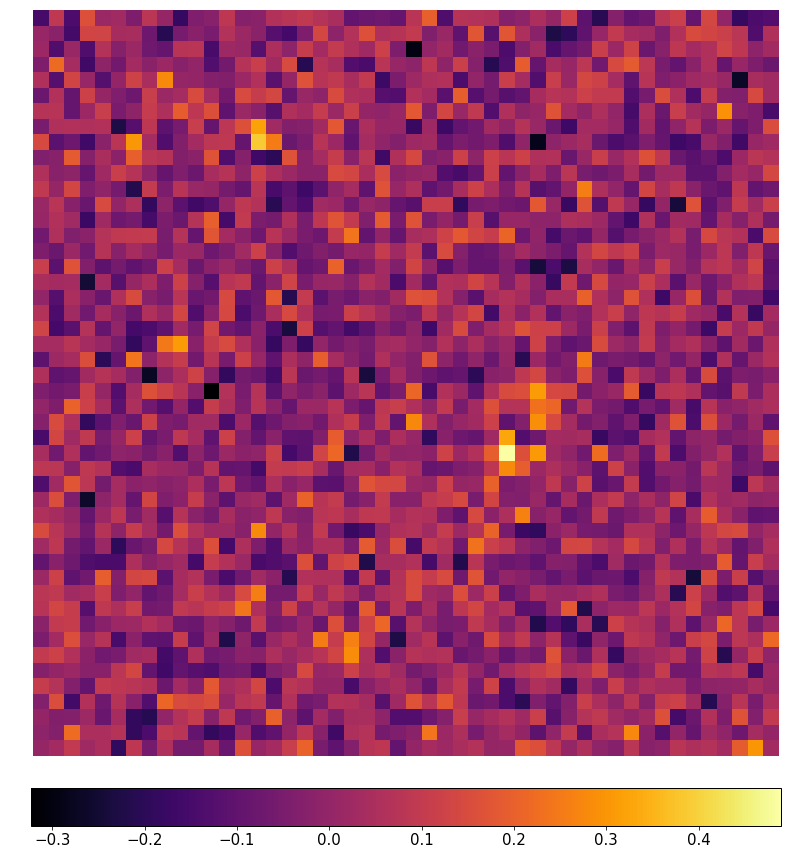

In [373]:
crop=30
plt.figure(figsize=(15,15))
# plt.title('Inspect average')
plt.axis('off')
plt.imshow(residual_minus[0,crop:-crop,crop:-crop],cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.savefig('/Users/mrizzo/Downloads/Minus_post_RDI.png',dpi=300)

In [374]:
from crispy.tools.postprocessing import scale2imgs
coefs, est = scale2imgs(plusIFS,
                        refIFS,
                        bowtie_mask=mask,
                        returndiff=False,
                        returnest=True)
residual_plus = plusIFS.data - est

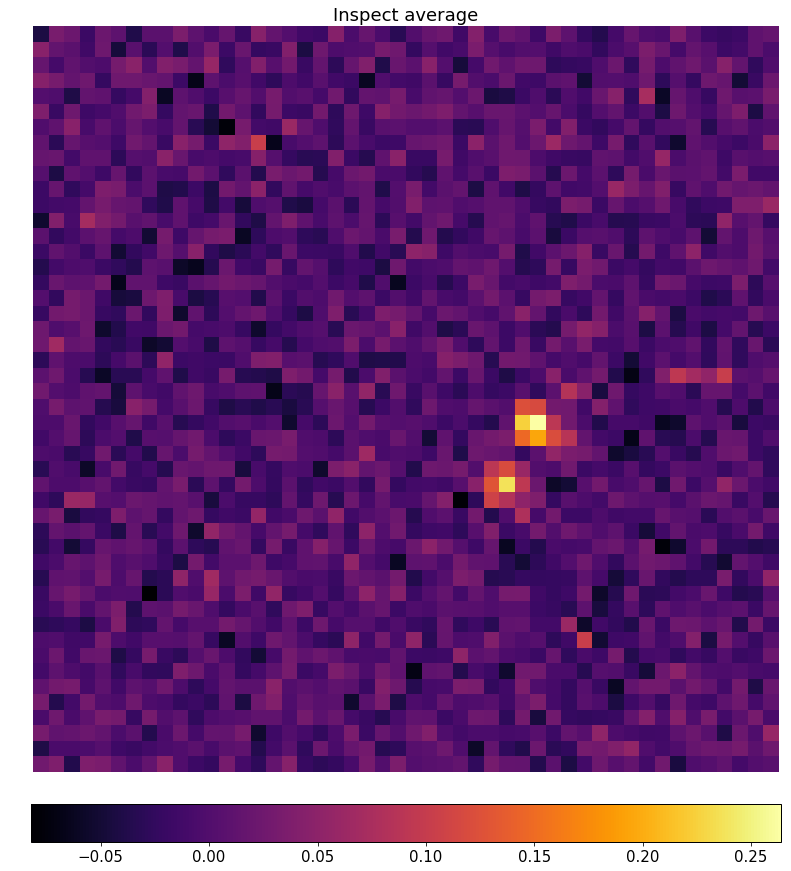

In [375]:
crop=30
plt.figure(figsize=(15,15))
plt.title('Inspect average')
plt.axis('off')
plt.imshow(np.mean(residual_plus,axis=0)[crop:-crop,crop:-crop],cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)


In [376]:
fits.writeto('/Users/mrizzo/IFS/OS6/roll_plus_RDI_spc.fits',residual_plus, overwrite=True)

## Inspect variance

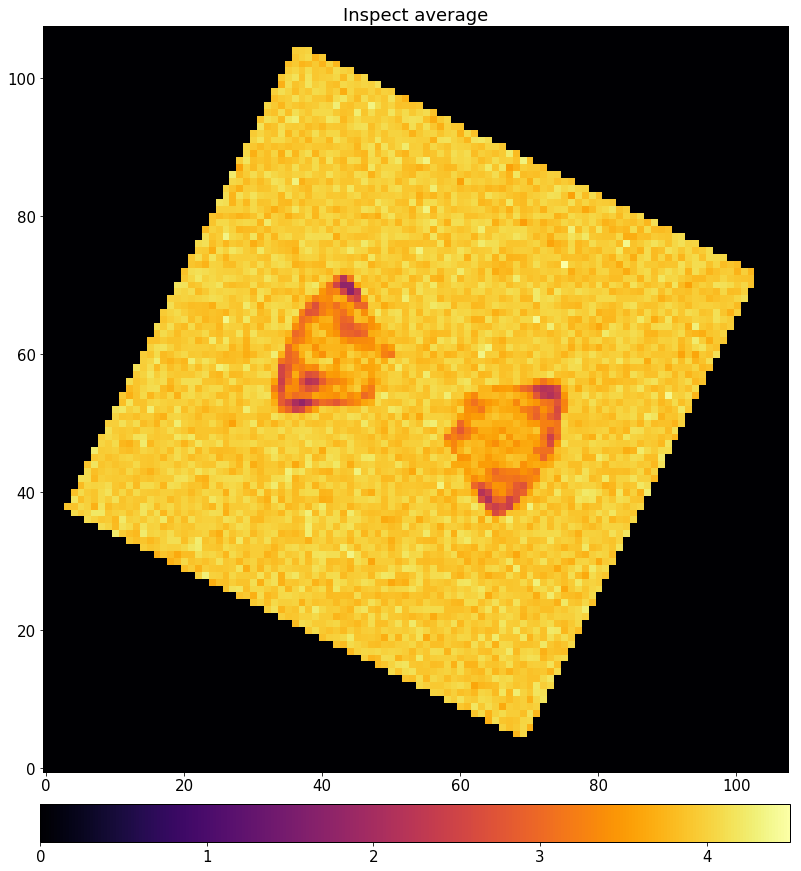

In [308]:
plt.figure(figsize=(15,15))
plt.title('Inspect average')
plt.imshow(minusIFS.ivar[0],cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)


# Process single off-axis maps

## Create off-axis image with no noise

In [341]:
planetpsf_roll2 = fits.getdata(spc_psf_path+'planet_psfs/os6_spc_770nm_psf_3.41_0.79.fits')
roll2 = interp(planetpsf_roll2,new_wavel)
psf_roll2 = Image(data=roll2*fieldmask[np.newaxis,:,:])
psf_roll2.header['LAM_C'] = 0.77
psf_roll2.header['PIXSIZE'] = 0.1
offaxis_roll2 = polychromeIFS(par,new_wavel*1000,psf_roll2,QE=False)


crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 17 seconds total


## Process offaxis image with no noise

In [357]:
perfect_IFS_Roll2 = reduceIFSMap(par,offaxis_roll2,name='refIFS',
                        method='sum',
                        smoothbad=False,
                        pixnoise=0,
                        fitbkgnd=False,
                        medsub=False,
                        gain=1.0,
                        niter=5
                       )

crispy - INFO - Mean, median, std: (1.146589951414572e-09, 0.0, 8.9534994806045167e-09)
crispy - INFO - Reduced cube will have 18 wavelength bins
crispy - INFO - Elapsed time: 2.643992s


In [336]:
print np.nansum(perfect_IFS_Roll2.data),np.sum(planetpsf_roll2),np.sum(offaxis_roll2)

2.0932192193 0.866946147539 11.4926639692


In [343]:
fits.writeto('/Users/mrizzo/Downloads/perfect_IFS_Roll2.fits',perfect_IFS_Roll2.data,overwrite=True)

## Construct matched filter from off-axis psf

In [358]:
from crispy.tools.postprocessing import mf

mf_roll2 = mf(perfect_IFS_Roll2,mask,0.0)
fits.writeto('/Users/mrizzo/Downloads/mf_roll2.fits',mf_roll2,overwrite=True)

## Measure spectrum for roll 2

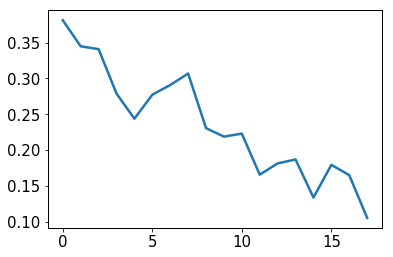

In [386]:
spectrum_roll2 = np.nansum(np.nansum(residual_plus*mf_roll2,axis=2),axis=1)
plt.plot(spectrum_roll2)

## Repeat for roll 1

In [370]:
planetpsf_roll1 = fits.getdata(spc_psf_path+'planet_psfs/os6_spc_770nm_psf_3.41_-0.79.fits')
roll1 = interp(planetpsf_roll1,new_wavel)
psf_roll1 = Image(data=roll1*fieldmask[np.newaxis,:,:])
psf_roll1.header['LAM_C'] = 0.77
psf_roll1.header['PIXSIZE'] = 0.1
offaxis_roll1 = polychromeIFS(par,new_wavel*1000,psf_roll1,QE=False)

perfect_IFS_Roll1 = reduceIFSMap(par,offaxis_roll1,name='refIFS',
                        method='sum',
                        smoothbad=False,
                        pixnoise=0,
                        fitbkgnd=False,
                        medsub=False,
                        gain=1.0,
                        niter=5
                       )


crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 21 seconds total
crispy - INFO - Mean, median, std: (1.1674739394807891e-09, 0.0, 9.1321783582107967e-09)
crispy - INFO - Reduced cube will have 18 wavelength bins
crispy - INFO - Elapsed time: 2.762208s


NameError: name 'v' is not defined

In [379]:
mf_roll1 = mf(perfect_IFS_Roll1,mask,0.0)
fits.writeto('/Users/mrizzo/Downloads/mf_roll1.fits',mf_roll1,overwrite=True)

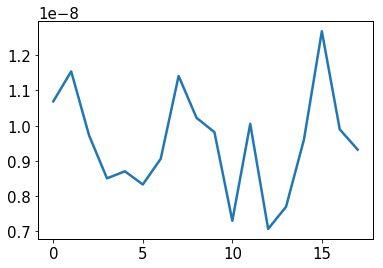

In [412]:
norm_roll1 = residual_minus*ratio_roll1[:,np.newaxis,np.newaxis]/(55*120)
spectrum_roll1 = np.nansum(np.nansum(norm_roll1*mf_roll1,axis=2),axis=1)
plt.plot(spectrum_roll1)


## Plot sum of both spectra

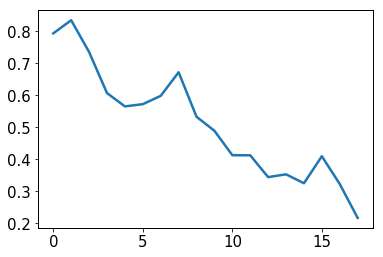

In [388]:
plt.plot(spectrum_roll1+spectrum_roll2)

## Propagate star onto offaxis positions

In [389]:
psf_roll1 = Image(data=roll1*convert_cube_target)
psf_roll1.header['LAM_C'] = 0.77
psf_roll1.header['PIXSIZE'] = 0.1
offaxis_roll1_star = polychromeIFS(par,new_wavel*1000,psf_roll1,QE=True)
fits.writeto('/Users/mrizzo/IFS/OS6/SPC/IFSraw/offaxis_roll1_star.fits',offaxis_roll1_star,overwrite=True)
psf_roll2 = Image(data=roll2*convert_cube_target)
psf_roll2.header['LAM_C'] = 0.77
psf_roll2.header['PIXSIZE'] = 0.1
offaxis_roll2_star = polychromeIFS(par,new_wavel*1000,psf_roll2,QE=True)
fits.writeto('/Users/mrizzo/IFS/OS6/SPC/IFSraw/offaxis_roll2_star.fits',offaxis_roll2_star,overwrite=True)

crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 17 seconds total
crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Done.
crispy - INFO - Performance: 20 seconds total


## Extract star

In [391]:
star_Roll1 = reduceIFSMap(par,offaxis_roll1_star,
                        method='sum',
                        smoothbad=False,
                        pixnoise=0,
                        fitbkgnd=False,
                        medsub=False,
                        gain=1.0,
                        niter=5
                       )
star_Roll2 = reduceIFSMap(par,offaxis_roll2_star,
                        method='sum',
                        smoothbad=False,
                        pixnoise=0,
                        fitbkgnd=False,
                        medsub=False,
                        gain=1.0,
                        niter=5
                       )


crispy - INFO - Mean, median, std: (0.00090297002853040927, 0.0, 0.007095409915314598)
crispy - INFO - Reduced cube will have 18 wavelength bins
crispy - INFO - Elapsed time: 2.560128s
crispy - INFO - Mean, median, std: (0.00087366487647785212, 0.0, 0.0068706163884049293)
crispy - INFO - Reduced cube will have 18 wavelength bins
crispy - INFO - Elapsed time: 2.937634s


In [402]:
ratio_roll1 = 1. / np.nanmax(np.nanmax(star_Roll1.data, axis=2), axis=1)
ratio_roll2 = 1. / np.nanmax(np.nanmax(star_Roll2.data, axis=2), axis=1)


In [411]:
print np.nanmax(np.nanmax(star_Roll1.data, axis=2), axis=1)

[ 5847.09295751  6433.28792311  6150.16449435  5852.42966464  5605.22594927
  5372.99079628  5147.94552723  4853.13170053  4487.48239464  4180.54837475
  3951.19581469  3727.49640549  3504.1727817   3280.8193865   3029.67692716
  2756.58751858  2423.86905618  1823.56980025]


5113642.26986


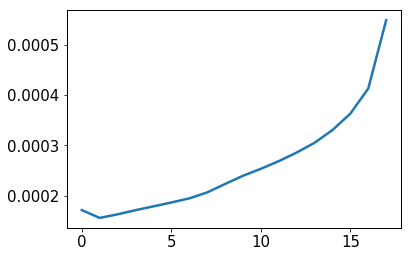

In [403]:
plt.plot(ratio_roll1)
print np.nansum(offaxis_roll1_star)

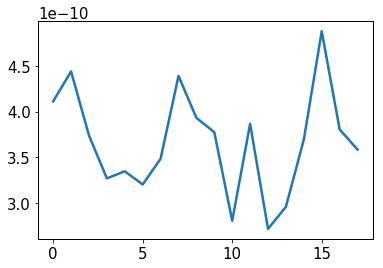

In [404]:
plt.plot(spectrum_roll1*ratio_roll1/(26*55*120))

# Reproduce results with a more on-axis PSF

## Add filter bandpass

[ 0.7         0.70583333  0.71166667  0.7175      0.72333333  0.72916667
  0.735       0.74083333  0.74666667  0.7525      0.75833333  0.76416667
  0.77        0.77583333  0.78166667  0.7875      0.79333333  0.79916667
  0.805       0.81083333  0.81666667  0.8225      0.82833333  0.83416667
  0.84      ]


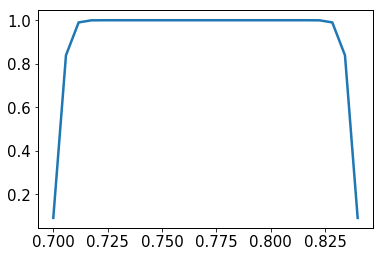

In [9]:
new_wavel = np.linspace(0.7,0.84,25)
minlam = 700./1000.
maxlam = 840./1000.
clam = 770./1000.
hw = 68./1000.
exponent = 30.
print new_wavel
f = np.exp(-((new_wavel-clam)/hw)**exponent)
plt.plot(new_wavel,f)

## Add offaxis planet at single roll

crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Writing data to ..//SimResults/detectorFramepoly.fits
crispy - INFO - Writing data to ..//SimResults/detectorFrame.fits
crispy - INFO - Done.
crispy - INFO - Performance: 17 seconds total


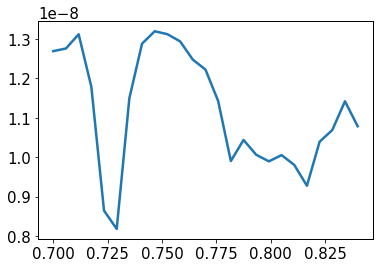

In [20]:
from scipy import ndimage
from crispy.tools.inputScene import calc_contrast
from crispy.IFS import polychromeIFS
from crispy.tools.image import Image
os.chdir('/Users/mrizzo/IFS/crispy/crispy/WFIRST/')
from params import Params
par = Params()

convert_cube_ref = ref_star_conv[:,np.newaxis,np.newaxis]
convert_cube_target = target_star_conv[:,np.newaxis,np.newaxis]


planetpsf_roll = fits.getdata(spc_psf_path+'planet_psfs/os6_spc_770nm_psf_4.80_0.00.fits')
planetroll = interp(planetpsf_roll,new_wavel)
fits.writeto('/Users/mrizzo/Downloads/planetpsf_roll.fits',planetroll,overwrite=True)
contrast = calc_contrast(new_wavel*1000,1.5,1,par.codeRoot +'/Inputs/Jupiter_1x_5AU_90deg.dat').value
plt.plot(new_wavel,contrast)
psf_roll = Image(data=planetroll*convert_cube_target*contrast[:,np.newaxis,np.newaxis]*f[:,np.newaxis,np.newaxis])
psf_roll.header['LAM_C'] = 0.77
psf_roll.header['PIXSIZE'] = 0.1
offaxis_roll = polychromeIFS(par,new_wavel*1000,psf_roll,QE=True)
fits.writeto('/Users/mrizzo/IFS/OS6/SPC/IFSraw/offaxis_roll.fits',offaxis_roll,overwrite=True)


## Create detector maps

In [21]:
from crispy.tools.detector import readoutPhotonFluxMapWFIRST as readoutWFIRST

timesteps_fname = os.path.join(spc_psf_path, 'os6_timesteps.txt')
timesteps = np.loadtxt(timesteps_fname,skiprows=1)

print timesteps.shape
startype = timesteps[:,0]
timestep = timesteps[:,1]
roll = timesteps[:,3]

Ndat_in_chunk = 55 # number of frames in a single chunk
datsize = timesteps.shape[0]

chunks_ind = np.split(np.arange(datsize),datsize/Ndat_in_chunk)
print "Number of chunks:",len(chunks_ind)

offaxis_roll = fits.getdata('/Users/mrizzo/IFS/OS6/SPC/IFSraw/offaxis_roll.fits')

data_average=[]
for j in range(len(chunks_ind)):
    chunk_indiv_frame = []
    if j%(len(chunks_ind)//10)==0: print j,"/",len(chunks_ind)
    for i in range(len(chunks_ind[j])):
        ind = chunks_ind[j][i]
        fname = '/Users/mrizzo/IFS/OS6/SPC/IFSraw/os6_%d.fits' % ind
        hdu = fits.open(fname)
        o = hdu[0].data#[350:680,225:815]
        if startype[ind]!=1: 
            o += offaxis_roll#[350:680,225:815]
        o[o<0.0] = 0.0
        obs = readoutWFIRST(o.T,
                                tottime=120,
                                inttime=120,
                                PCcorrect=False, # don't correct for photon counting bias
                                PCmode = False,
                                crrate = 5.0,
                                hprate = 3.0,
                                lifefraction=0.5,
                                xs=2100,ys=1100,
                                QE = 1.0,
                                ).astype(np.int)
        hdu.close()
        fits.writeto('/Users/mrizzo/IFS/OS6/SPC/IFSdetector/os6_%d.fits' % ind,obs,overwrite=True)
        chunk_indiv_frame.append(obs)
    data_average.append(np.nansum(np.array(chunk_indiv_frame),axis=0))
data_average = np.array(data_average)



(3630, 4)
Number of chunks: 66
0 / 66
6 / 66
12 / 66
18 / 66
24 / 66
30 / 66
36 / 66
42 / 66
48 / 66
54 / 66
60 / 66


## Process maps and take averages

In [22]:
timesteps_fname = os.path.join(spc_psf_path, 'os6_timesteps.txt')
timesteps = np.loadtxt(timesteps_fname,skiprows=1)

print timesteps.shape
startype = timesteps[:,0]
timestep = timesteps[:,1]
roll = timesteps[:,3]


Ndat_in_chunk = 55 # number of frames in a single chunk
datsize = timesteps.shape[0]
reference_chunks_ind = []
roll_plus_chunks_ind = []
roll_minus_chunks_ind = []
# cut into chunks
chunks_ind = np.split(np.arange(datsize),datsize/Ndat_in_chunk)



for j in range(len(chunks_ind)):
    i = chunks_ind[j][0]
    if startype[i]==1: reference_chunks_ind.append(chunks_ind[j])
    elif roll[i]==1 or roll[i]==3: roll_minus_chunks_ind.append(chunks_ind[j])
    else: roll_plus_chunks_ind.append(chunks_ind[j])



print 'Summary:'
print 'There are %d reference chunks' % len(reference_chunks_ind)
print 'There are %d target chunks with minus 13deg roll' % len(roll_minus_chunks_ind)
print 'There are %d target chunks with plus 13deg roll' % len(roll_plus_chunks_ind)


from crispy.tools.detector import readoutPhotonFluxMapWFIRST as readoutWFIRST
reference_data_average = []
for j in range(len(reference_chunks_ind)):
    chunk_indiv_frame = []
    for i in range(len(reference_chunks_ind[j])):
        ind = reference_chunks_ind[j][i]
        fname = '/Users/mrizzo/IFS/OS6/SPC/IFSdetector/os6_%d.fits' % ind
        hdu = fits.open(fname)
        obs = hdu[0].data
        hdu.close()
        for ix in range(obs.shape[0]):
            for iy in range(obs.shape[1]):
                if obs[ix,iy]>60000:
                    obs[ix,:] = 0
                    if ix+1<obs.shape[0]: obs[ix+1,:] = 0
                    continue
        mask = obs>600
        obs[mask] = 1
        obs[~mask] = 0
        chunk_indiv_frame.append(obs)
    reference_data_average.append(np.nansum(chunk_indiv_frame,axis=0))
print 'Done with reference'
roll_minus_data_average = []
for j in range(len(roll_minus_chunks_ind)):
    chunk_indiv_frame = []
    for i in range(len(roll_minus_chunks_ind[j])):
        ind = roll_minus_chunks_ind[j][i]
        fname = '/Users/mrizzo/IFS/OS6/SPC/IFSdetector/os6_%d.fits' % ind
        hdu = fits.open(fname)
        obs = hdu[0].data
        hdu.close()
        for ix in range(obs.shape[0]):
            for iy in range(obs.shape[1]):
                if obs[ix,iy]>60000:
                    obs[ix,:] = 0
                    if ix+1<obs.shape[0]: obs[ix+1,:] = 0
                    continue
        mask = obs>600
        obs[mask] = 1
        obs[~mask] = 0
        chunk_indiv_frame.append(obs)
    roll_minus_data_average.append(np.nansum(chunk_indiv_frame,axis=0))
print 'Done with minus roll'

roll_plus_data_average = []
for j in range(len(roll_plus_chunks_ind)):
    chunk_indiv_frame = []
    for i in range(len(roll_plus_chunks_ind[j])):
        ind = roll_plus_chunks_ind[j][i]
        fname = '/Users/mrizzo/IFS/OS6/SPC/IFSdetector/os6_%d.fits' % ind
        hdu = fits.open(fname)
        obs = hdu[0].data
        hdu.close()
        
        for ix in range(obs.shape[0]):
            for iy in range(obs.shape[1]):
                if obs[ix,iy]>60000:
                    obs[ix,:] = 0
                    if ix+1<obs.shape[0]: obs[ix+1,:] = 0
                    continue
        mask = obs>600
        obs[mask] = 1
        obs[~mask] = 0
        chunk_indiv_frame.append(obs)
    roll_plus_data_average.append(np.nansum(chunk_indiv_frame,axis=0))
print 'Done with plus roll'


fits.writeto('/Users/mrizzo/IFS/OS6/references_haystacks_spc.fits',np.array(reference_data_average), overwrite=True)
fits.writeto('/Users/mrizzo/IFS/OS6/roll_minus_haystacks_spc.fits',np.array(roll_minus_data_average), overwrite=True)
fits.writeto('/Users/mrizzo/IFS/OS6/roll_plus_haystacks_spc.fits',np.array(roll_plus_data_average), overwrite=True)

(3630, 4)
Summary:
There are 14 reference chunks
There are 26 target chunks with minus 13deg roll
There are 26 target chunks with plus 13deg roll
Done with reference
Done with minus roll
Done with plus roll


In [23]:
ref = np.mean(np.array(reference_data_average),axis=0)
target_all = np.concatenate([roll_minus_data_average,roll_plus_data_average])
print target_all.shape
target = np.mean(np.array(target_all),axis=0)
print target.shape


(52, 1024, 1024)
(1024, 1024)


In [24]:
fits.writeto('/Users/mrizzo/IFS/OS6/ref_haystacks_spc_ave.fits',ref, overwrite=True)
fits.writeto('/Users/mrizzo/IFS/OS6/target_haystacks_spc_ave.fits',target, overwrite=True)


## plot image with cosmic rays

In [39]:
reference_data_average = []
for j in range(len(reference_chunks_ind)):
    chunk_indiv_frame = []
    for i in range(len(reference_chunks_ind[j])):
        ind = reference_chunks_ind[j][i]
        fname = '/Users/mrizzo/IFS/OS6/SPC/IFSdetector/os6_%d.fits' % ind
        hdu = fits.open(fname)
        obs = hdu[0].data
        hdu.close()
#         for ix in range(obs.shape[0]):
#             for iy in range(obs.shape[1]):
#                 if obs[ix,iy]>60000:
#                     obs[ix,:] = 0
#                     if ix+1<obs.shape[0]: obs[ix+1,:] = 0
#                     continue
#         mask = obs>600
#         obs[mask] = 1
#         obs[~mask] = 0
        chunk_indiv_frame.append(obs)
    reference_data_average.append(np.nansum(chunk_indiv_frame,axis=0))
fits.writeto('/Users/mrizzo/IFS/OS6/references_haystacks_spc_wCR.fits',np.array(reference_data_average), overwrite=True)


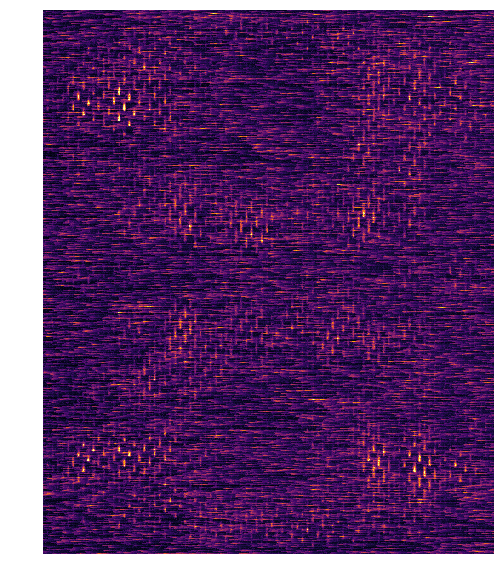

In [48]:
plt.figure(figsize=(10,10))
# plt.title('Average reference star with cosmic rays')
plt.imshow(reference_data_average[0][200:840,250:780],cmap=cmap,vmax=4e5)
plt.axis('off')
# plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.savefig('/Users/mrizzo/Downloads/Reference_w_CR.png',dpi=300)

## Extract IFS maps

In [25]:
from crispy.IFS import reduceIFSMap
import os
os.chdir('/Users/mrizzo/IFS/crispy/crispy/WFIRST/')
from params import Params
par = Params()

IFSmap = np.zeros((1024,1024))
IFSmap = ref.T-1
refIFS = reduceIFSMap(par,IFSmap,name='refIFS',
                        method='lstsq_conv',
                        smoothbad=False,
                        pixnoise=2,
                        fitbkgnd=False,
                        medsub=False,
                        gain=1.0,
                        niter=5
                       )
# IFSmap[350:680,225:815] = plus.T-1
IFSmap = target.T-1

targetIFS = reduceIFSMap(par,IFSmap,name='targetIFS',
                        method='lstsq_conv',
                        smoothbad=False,
                        pixnoise=2,
                        fitbkgnd=False,
                        medsub=False,
                        gain=1.0,
                        niter=5
                       )


crispy - INFO - Mean, median, std: (-0.61344283044824643, -0.64285714285714279, 0.17268581866491362)
crispy - INFO - Reduced cube will have 18 wavelength bins
crispy - INFO - Writing data to ..//SimResults/refIFS_red_lstsq_conv_resid.fits
crispy - INFO - Writing data to ..//SimResults/refIFS_red_lstsq_conv_model.fits
crispy - INFO - Writing data to ..//SimResults/refIFS_red_lstsq_conv_chisq.fits
crispy - INFO - Elapsed time: 41.390637s
crispy - INFO - Mean, median, std: (-0.63134530829337532, -0.63461538461538458, 0.085504232403224883)
crispy - INFO - Reduced cube will have 18 wavelength bins
crispy - INFO - Writing data to ..//SimResults/targetIFS_red_lstsq_conv_resid.fits
crispy - INFO - Writing data to ..//SimResults/targetIFS_red_lstsq_conv_model.fits
crispy - INFO - Writing data to ..//SimResults/targetIFS_red_lstsq_conv_chisq.fits
crispy - INFO - Elapsed time: 44.258778s


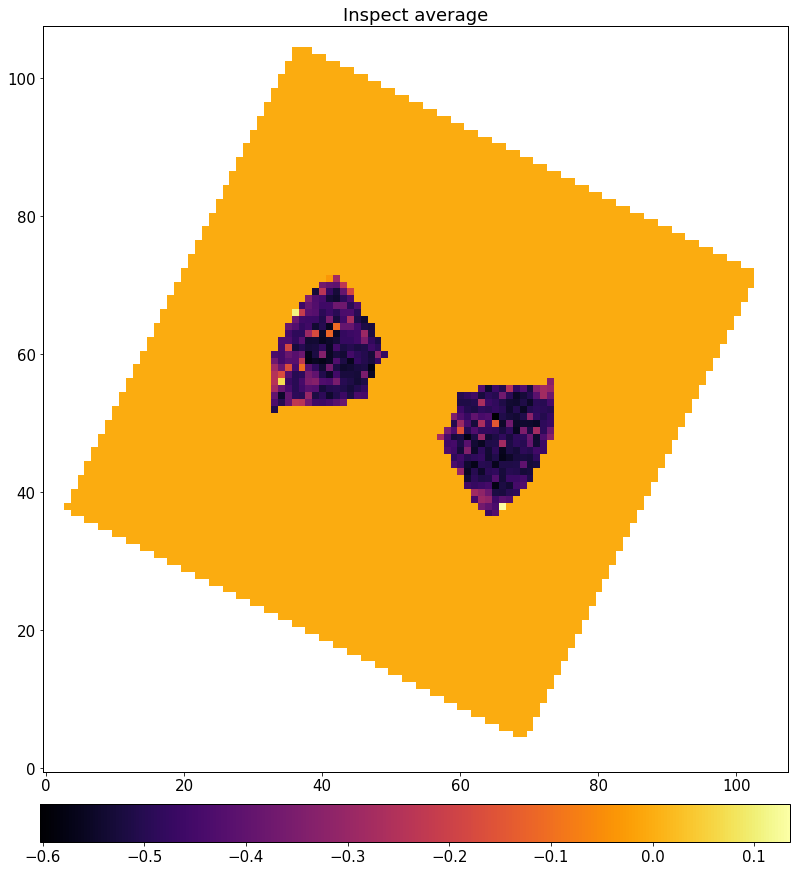

In [26]:
from crispy.tools.imgtools import bowtie

ydim,xdim=targetIFS.data[0].shape
lamc=770.
IWA = 2.8
OWA=9.
mask, scratch = bowtie(targetIFS.data[0], ydim //
                       2 -
                       1, xdim //
                       2, openingAngle=65, clocking=-
                       par.philens *
                       180. /
                       np.pi, IWApix=IWA *
                       lamc /
                       par.lenslet_wav /
                       par.lenslet_sampling, OWApix=OWA *
                       lamc /
                       par.lenslet_wav /
                       par.lenslet_sampling, export=None, twomasks=False)

plt.figure(figsize=(15,15))
plt.title('Inspect average')
plt.imshow(targetIFS.data[0]*mask,cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)


## RDI

In [27]:
from crispy.tools.postprocessing import scale2imgs
coefs, est = scale2imgs(targetIFS,
                        refIFS,
                        bowtie_mask=mask,
                        returndiff=False,
                        returnest=True)
residual_target = targetIFS.data - est

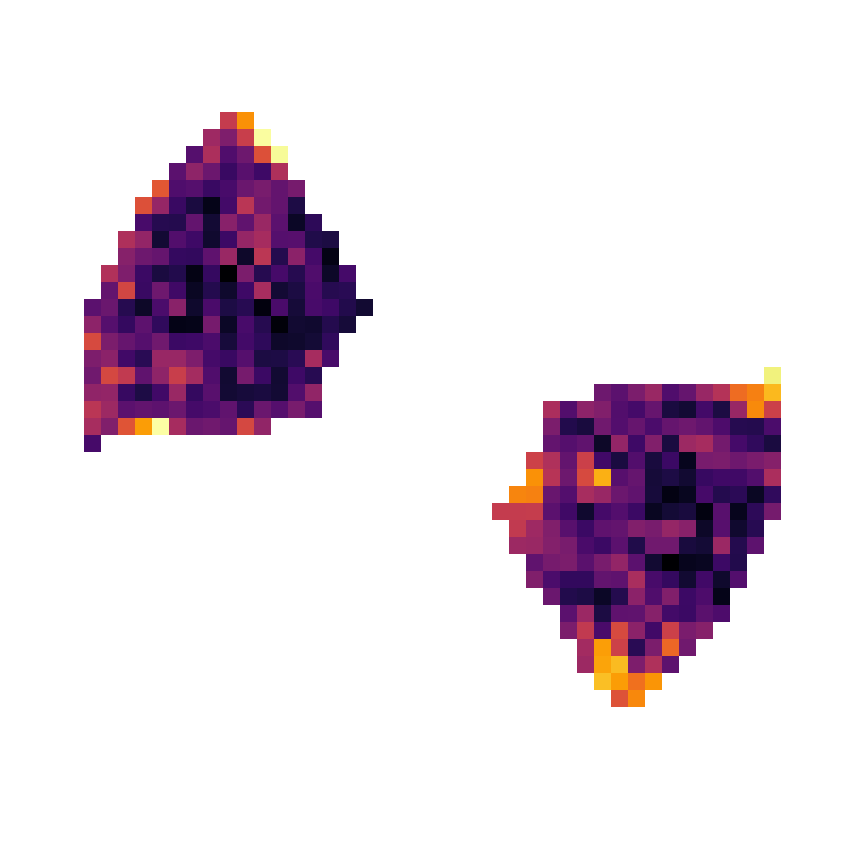

In [53]:
crop=30
plt.figure(figsize=(15,15))
# plt.title('Inspect average')
plt.axis('off')
targetIFSdata = targetIFS.data.copy()*mask[np.newaxis,:,:]
targetIFSdata[targetIFSdata==0.0] = np.NaN
plt.imshow(np.nanmean(targetIFSdata[:,crop:-crop,crop:-crop],axis=0),cmap=cmap)
# plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.savefig('/Users/mrizzo/Downloads/target_average_before_RDI.png',dpi=300)

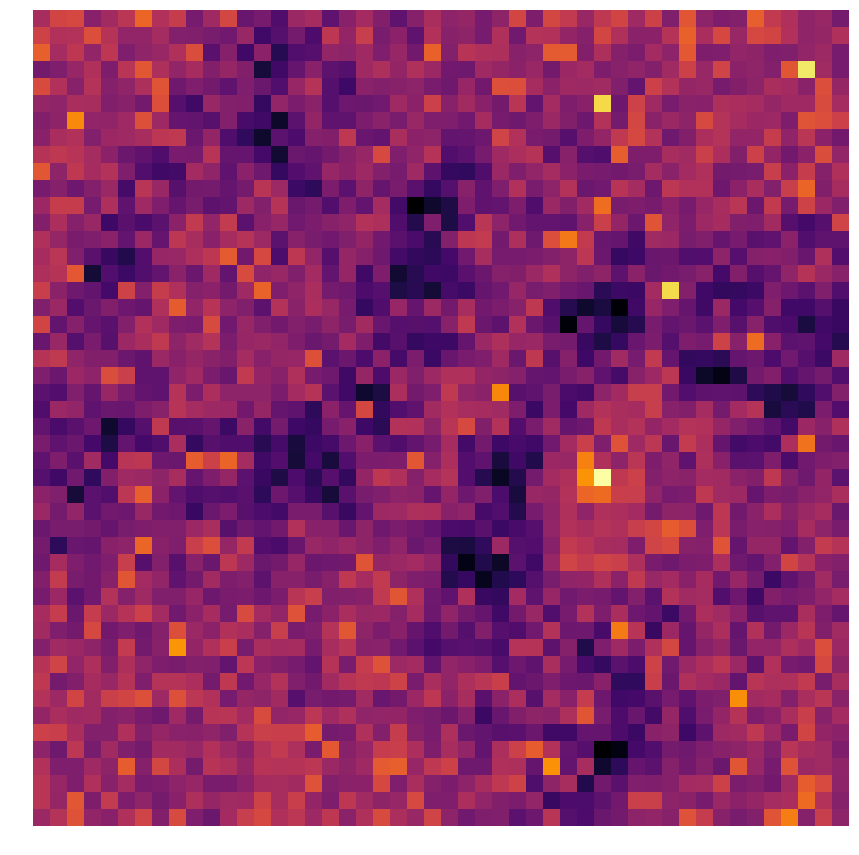

In [54]:
crop=30
plt.figure(figsize=(15,15))
# plt.title('Inspect average')
plt.axis('off')
plt.imshow(np.mean(residual_target[:,crop:-crop,crop:-crop],axis=0),cmap=cmap)
# plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.savefig('/Users/mrizzo/Downloads/target_average_after_RDI.png',dpi=300)

## Propagate star at same off-axis location as planet

In [30]:
from scipy import ndimage
def interp(data,new_wavel):
    nl,nx,ny = data.shape
    x = np.arange(nx)
    y = np.arange(ny)
    new_wavel = np.linspace(0.7,0.84,25)
    l = (new_wavel-np.amin(new_wavel))*(nl-1)/(np.amax(new_wavel)-np.amin(new_wavel))
    l,x,y = np.meshgrid(l,x,y)
    newpsf = ndimage.map_coordinates(data,[l,x,y],prefilter=False,mode='nearest',order=1)
    return np.swapaxes(newpsf,0,1)

crispy - INFO - The number of input pixels per lenslet is 4.285714
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Writing data to ..//SimResults/detectorFramepoly.fits
crispy - INFO - Writing data to ..//SimResults/detectorFrame.fits
crispy - INFO - Done.
crispy - INFO - Performance: 18 seconds total


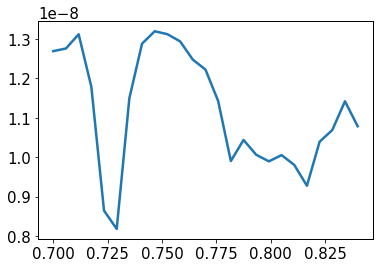

In [31]:
from crispy.tools.inputScene import calc_contrast
from crispy.tools.image import Image
from crispy.IFS import polychromeIFS
fieldmask = fits.getdata(spc_psf_path+'field_mask.fits')

convert_cube_ref = ref_star_conv[:,np.newaxis,np.newaxis]*fieldmask[np.newaxis,:,:]
convert_cube_target = target_star_conv[:,np.newaxis,np.newaxis]*fieldmask[np.newaxis,:,:]
new_wavel = np.linspace(0.7,0.84,25)
planetpsf_roll = fits.getdata(spc_psf_path+'planet_psfs/os6_spc_770nm_psf_4.80_0.00.fits')
planetroll = interp(planetpsf_roll,new_wavel)
contrast = calc_contrast(new_wavel*1000,1.5,1,par.codeRoot +'/Inputs/Jupiter_1x_5AU_90deg.dat').value
plt.plot(new_wavel,contrast)
psf_roll = Image(data=planetroll*convert_cube_target*f[:,np.newaxis,np.newaxis])
psf_roll.header['LAM_C'] = 0.77
psf_roll.header['PIXSIZE'] = 0.1
offaxis_roll = polychromeIFS(par,new_wavel*1000,psf_roll,QE=True)


## Adds Poisson noise

In [32]:
offaxis_roll[offaxis_roll<0]=0.0
noisy_star = np.random.poisson(offaxis_roll)

## Extract star map

In [33]:
perfectStar = reduceIFSMap(par,offaxis_roll,name='perfectStarIFS',
                        method='lstsq_conv',
                        smoothbad=False,
                        pixnoise=0,
                        fitbkgnd=False,
                        medsub=False,
                        gain=1.0,
                        niter=5
                       )

crispy - INFO - Mean, median, std: (0.0019092717001537376, 0.0, 0.015128005507465601)
crispy - INFO - Reduced cube will have 18 wavelength bins
crispy - INFO - Writing data to ..//SimResults/perfectStarIFS_red_lstsq_conv_resid.fits
crispy - INFO - Writing data to ..//SimResults/perfectStarIFS_red_lstsq_conv_model.fits
crispy - INFO - Writing data to ..//SimResults/perfectStarIFS_red_lstsq_conv_chisq.fits
crispy - INFO - Elapsed time: 38.281683s


In [35]:
starIFS = reduceIFSMap(par,noisy_star.astype(np.float),name='starIFS',
                        method='lstsq_conv',
                        smoothbad=False,
                        pixnoise=0,
                        fitbkgnd=False,
                        medsub=False,
                        gain=1.0,
                        niter=5
                       )

crispy - INFO - Mean, median, std: (0.0, 0.0, 0.0)
crispy - INFO - Reduced cube will have 18 wavelength bins
crispy - INFO - Writing data to ..//SimResults/starIFS_red_lstsq_conv_resid.fits
crispy - INFO - Writing data to ..//SimResults/starIFS_red_lstsq_conv_model.fits
crispy - INFO - Writing data to ..//SimResults/starIFS_red_lstsq_conv_chisq.fits
crispy - INFO - Elapsed time: 38.443914s


## Construct star ratio

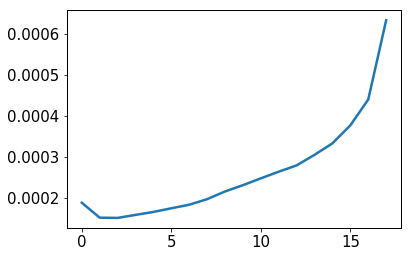

In [36]:
ratio = 1. / np.nanmax(np.nanmax(starIFS.data, axis=2), axis=1)
plt.plot(ratio)

## Apply contrast normalization

crispy - INFO - Reduced cube will have 18 wavelength bins
[ 704.25443039  711.41747416  718.65337398  725.96287087  733.34671341
  740.80565776  748.34046779  755.95191515  763.64077932  771.40784771
  779.25391575  787.17978694  795.18627299  803.27419382  811.44437771
  819.69766139  828.03489005  836.45691752]


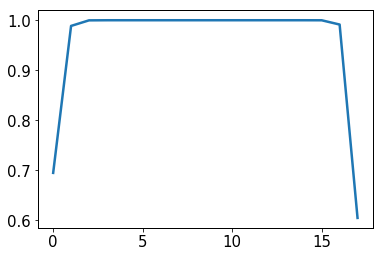

In [37]:
from crispy.tools.reduction import calculateWaveList
wavs,_ = calculateWaveList(par)
print wavs
newf =  np.exp(-((wavs/1000.-clam)/hw)**exponent)
plt.plot(newf)

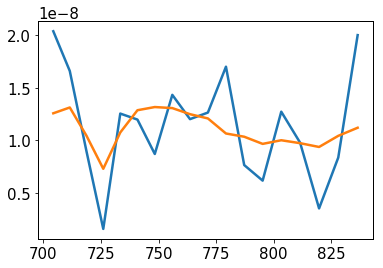

In [55]:
from crispy.tools.postprocessing import mf
mf_target = mf(perfectStar,mask,0.0)
norm_target = residual_target*ratio[:,np.newaxis,np.newaxis]/(55*120)
spectrum = np.nansum(np.nansum(norm_target*mf_target,axis=2),axis=1)
plt.plot(wavs,spectrum/newf*np.exp(100. * 6. / 5000.)*5)
mewcontrast = calc_contrast(wavs,1.5,1,par.codeRoot +'/Inputs/Jupiter_1x_5AU_90deg.dat').value

plt.plot(wavs,mewcontrast)


## Make pretty plot

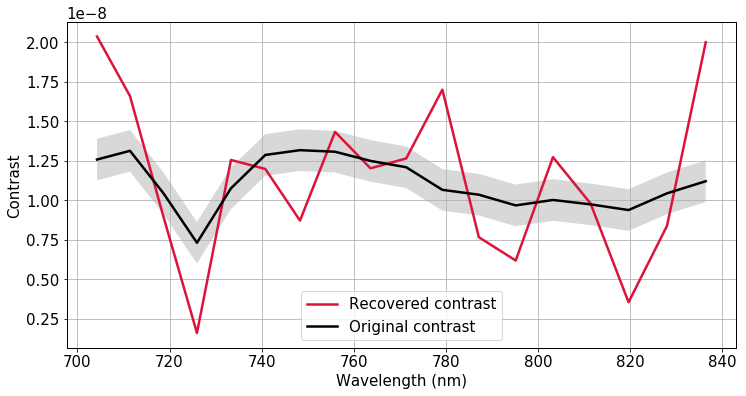

In [58]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(wavs,spectrum/newf*np.exp(100. * 6. / 5000.)*5,label='Recovered contrast',color='crimson')
ax.plot(wavs,mewcontrast,label='Original contrast',c='k')
ax.fill_between(
    wavs,
    mewcontrast - 0.1 * np.amax(mewcontrast),
    mewcontrast + 0.1 * np.amax(mewcontrast),
    alpha=0.3,
    facecolor='Gray')
ax.grid('on')
ax.set_ylabel('Contrast')
ax.set_xlabel('Wavelength (nm)')
plt.legend()
plt.savefig('/Users/mrizzo/Downloads/Spectra_recovered.png',dpi=300)

# Process AJ's SPC off-axis PSFs

In [ ]:
SPC_offaxis = fits.getdata(spc_psf_path+'data_offaxis_PSFs_SPC20170714.fits')
xoffsets = np.loadtxt(spc_psf_path+'x_vector.txt')
yoffsets = np.loadtxt(spc_psf_path+'y_vector.txt')
cormask =  fits.getdata(spc_psf_path+'mapping_used_points_in_dark_hole.fits')

In [ ]:
print SPC_offaxis.shape
i=40
print xoffsets[i],yoffsets[i]
plt.imshow(SPC_offaxis[i,0])

In [ ]:
xs,ys = cormask.shape
xs = np.arange(xs)
ys = np.arange(ys)
print cormask.shape
XS,YS = np.meshgrid(ys,xs)
print XS.shape

In [ ]:
cor_ind = np.where(cormask!=0)
print cor_ind,len(cor_ind)

In [ ]:
def indices(a, func):
    return [i for (i, val) in enumerate(a) if func(val)]
cor_ind = indices(cormask, lambda x: x > 0)


In [ ]:

XS_reshaped = np.reshape(XS,-1)
print len(XS_reshaped)
YS_reshaped = np.reshape(YS,-1)
cormask_reshaped = np.reshape(cormask,-1)
cor_ind = np.where(cormask_reshaped!=0)[0]
print len(cor_ind),cor_ind[50]
i=3
print XS_reshaped[cor_ind[i]],YS_reshaped[cor_ind[i]]